In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

# Import modules containing classes and functions needed for the simulation
from src.model_ctrl import RenG, gain
from src.model_sys import RobotsSystem, disturbance, computePriccati
from src.plots import plot_trajectories, plot_traj_vs_time
from src.loss_functions import f_loss_states, f_loss_u, f_loss_ca, f_loss_obst
from src.utils import calculate_collisions, set_params

In [2]:
# Set the random seed for reproducibility
torch.manual_seed(69)
# Set the parameters and hyperparameters for the simulation
params = set_params()
min_dist, t_end, n_agents, x0, xbar, learning_rate, epochs, Q, \
alpha_u, alpha_ca, alpha_obst, n_xi, l, n_traj, std_ini, gamma_bar, wmax, decayw,maxtimew = params

------- Print open loop trajectories --------


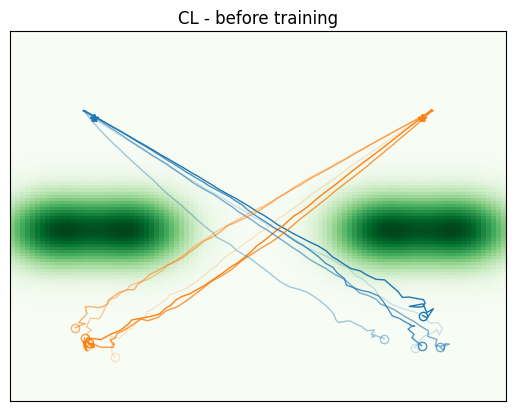

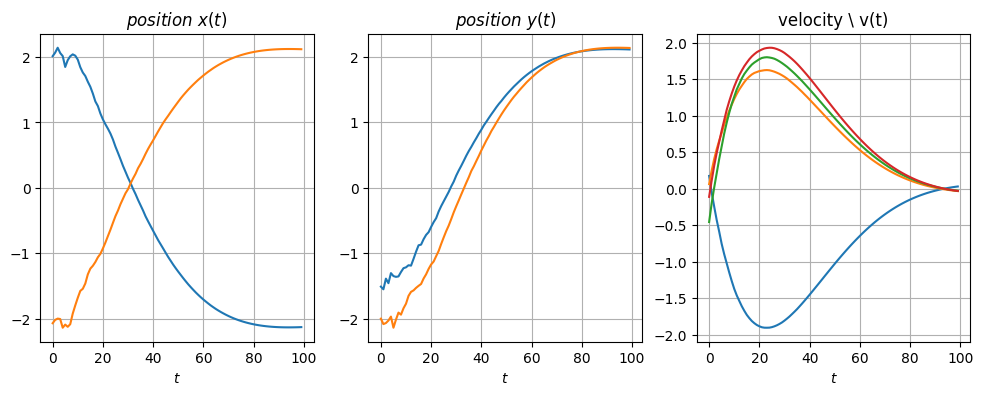

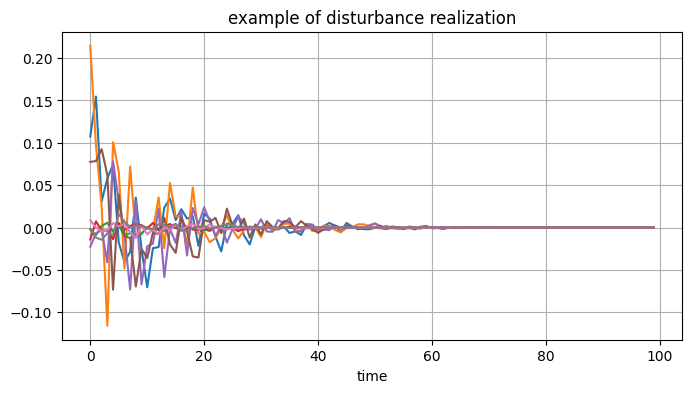

In [3]:
# Define the system and controller
#syst = TwoRobots(xbar,linear)
syst = RobotsSystem(xbar)
ctl = RenG(syst.n, syst.m, n_xi, l, bias=False, mode="l2stable", gamma=1)
amplifier = gain(gamma_bar)

# Define the optimizer and its parameters
optimizer = torch.optim.Adam([
                {'params': ctl.parameters()},
                {'params': amplifier.parameters(), 'lr': 1e-1}], lr=learning_rate)

time = torch.linspace(0, t_end, t_end+1)
# Plot and log the open-loop trajectories before training
print("------- Print open loop trajectories --------")
x_log = torch.zeros((t_end, syst.n, n_traj))
u = torch.zeros(syst.m)
for traj in range(n_traj):
    x = x0 + std_ini * torch.randn(x0.shape)
    w_in = torch.randn((t_end + 1, syst.n))
    for t in range(t_end):
        x_log[t, :,traj] = x
        w_syst = disturbance(t,w_in[t,:],wmax,decayw,maxtimew)
        x = syst(t, x, u, w_syst)
        
plot_trajectories(x_log, xbar, syst.n_agents, text="CL - before training", T=t_end, obst=alpha_obst)
plot_traj_vs_time(t_end, syst.n_agents, x_log[:,:,0])

w = disturbance(time,w_in,wmax,decayw,maxtimew)
plt.figure(figsize=(4 * 2, 4))
plt.plot(time[:t_end], w[:t_end,:])
plt.xlabel('time')
plt.title('example of disturbance realization')
plt.grid()
plt.show()

------------ Begin training ------------
Problem: RH neurSLS -- t_end: 100 -- lr: 1.00e-03 -- epochs: 1500 -- n_traj: 5 -- std_ini: 0.20 -- sym time: 5.0 s
 -- alpha_u: 0.0 -- alpha_ca: 100 -- alpha_obst: 5.0e+03
REN info -- n_xi: 5 -- l: 5
--------- --------- ---------  ---------
Epoch: 0 --- Loss: 282616.5938 ---||--- Loss x: 78352.43 --- Loss u: 0.13 --- Loss ca: 16679.96 --- Loss obst: 187584.08
Epoch: 200 --- Loss: 150141.0000 ---||--- Loss x: 85347.21 --- Loss u: 0.96 --- Loss ca: 3054.70 --- Loss obst: 61738.13
Epoch: 400 --- Loss: 126090.5781 ---||--- Loss x: 79068.48 --- Loss u: 1.49 --- Loss ca: 7266.01 --- Loss obst: 39754.59
Epoch: 600 --- Loss: 105490.6250 ---||--- Loss x: 79062.82 --- Loss u: 2.20 --- Loss ca: 3964.09 --- Loss obst: 22461.52
Epoch: 800 --- Loss: 103545.6719 ---||--- Loss x: 83451.66 --- Loss u: 4.46 --- Loss ca: 5855.20 --- Loss obst: 14234.35
Epoch: 1000 --- Loss: 101260.8672 ---||--- Loss x: 84049.77 --- Loss u: 5.86 --- Loss ca: 3397.79 --- Loss obst: 

Text(0.5, 1.0, '$training$ $loss$')

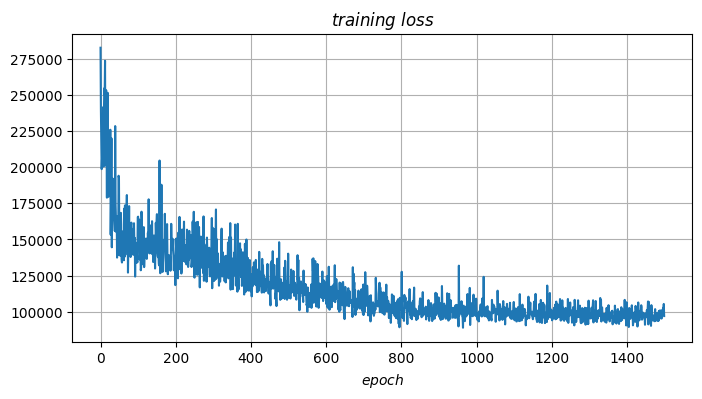

In [4]:
# # # # # # # # Train # # # # # # # #
# Train the controller using the NeurSLS algorithm
sim_time = t_end*syst.h
print("------------ Begin training ------------")
print("Problem: RH neurSLS -- t_end: %i" % t_end + " -- lr: %.2e" % learning_rate +
      " -- epochs: %i" % epochs + " -- n_traj: %i" % n_traj + " -- std_ini: %.2f" % std_ini + " -- sym time: %.1f s" % sim_time)
print(" -- alpha_u: %.1f" % alpha_u + " -- alpha_ca: %i" % alpha_ca + " -- alpha_obst: %.1e" % alpha_obst)
print("REN info -- n_xi: %i" % n_xi + " -- l: %i" % l)
print("--------- --------- ---------  ---------")


# Initialize arrays to store the loss and its components for each epoch
loss_list = np.zeros(epochs)

# Loop over the specified number of epochs
for epoch in range(epochs):
    # Reset the gradients of the optimizer
    optimizer.zero_grad()
    # Initialize the loss and its components for this epoch
    loss_x, loss_u, loss_ca, loss_obst = 0, 0, 0, 0

    # Loop over the specified number of trajectories
    for kk in range(n_traj):
        devx0 = std_ini * torch.randn(x0.shape)
        x = x0 + devx0
        w_in = torch.randn((t_end + 1, syst.n))
        xi = torch.zeros(ctl.n)
        w_REN = x0 - syst.xbar + devx0
        u, xi = ctl(0, w_REN, xi)
        usys = amplifier(u)
        for t in range(t_end):
            x_ = x
            # Compute the next state and control input using the systtem and controller models
            w_syst = disturbance(t, w_in[t, :], wmax, decayw, maxtimew)
            x = syst(t, x, usys, w_syst)
            w_REN = x - syst.f(t, x_, usys)
            u, xi = ctl(t, w_REN, xi)
            usys = amplifier(u)
            # Compute the loss and its components for this time step
            loss_x = loss_x + f_loss_states(t, x, syst, Q)
            loss_u = loss_u + alpha_u * f_loss_u(t, usys)
            loss_ca = loss_ca + alpha_ca * f_loss_ca(x, syst, min_dist)
            if alpha_obst != 0:
                loss_obst = loss_obst + alpha_obst * f_loss_obst(x)

    # Compute the total loss for this epoch and log its components
    loss = loss_x + loss_u + loss_ca + loss_obst
    if epoch%200==0:
        print("Epoch: %i --- Loss: %.4f ---||--- Loss x: %.2f --- " % (epoch, loss, loss_x) +
              "Loss u: %.2f --- Loss ca: %.2f --- Loss obst: %.2f" % (loss_u, loss_ca, loss_obst))
    loss_list[epoch] = loss.detach()

    # Backpropagate the loss through the controller model and update its parameters
    loss.backward(retain_graph=True)
    optimizer.step()
    ctl.set_param()


# Save the trained models to files
torch.save(ctl.state_dict(), "trained_models/offline_mountains_ctl.pt")
torch.save(optimizer.state_dict(), "trained_models/offline_mountains_opt.pt")
torch.save(amplifier.state_dict(), "trained_models/offline_mountains_amp.pt")


# # # # # # # # Print & plot results # # # # # # # #
# Plot the loss and its components over the epochs
t = torch.linspace(0, epochs - 1, epochs)
plt.figure(figsize=(4 * 2, 4))
plt.plot(t, loss_list[:])
plt.grid()
plt.xlabel(r'$epoch$')
plt.title(r'$training$ $loss$')

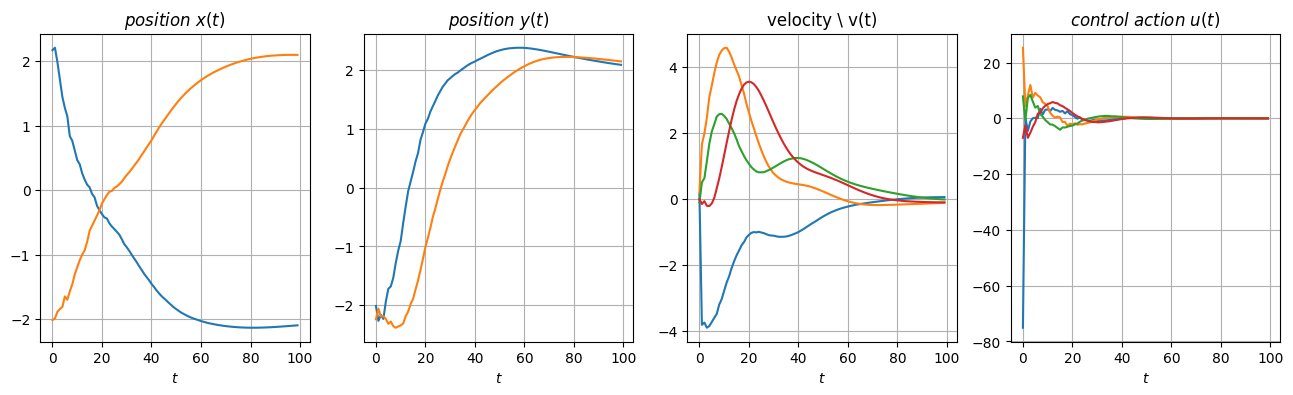

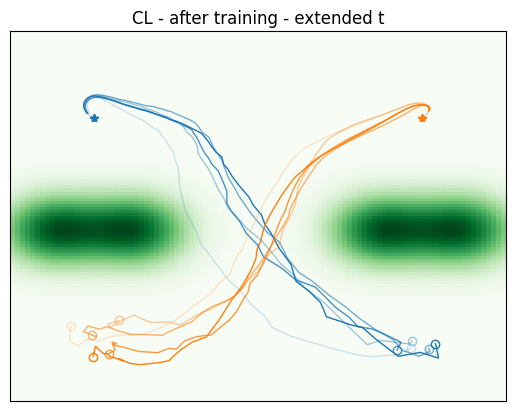

Number of collisions after training: 0


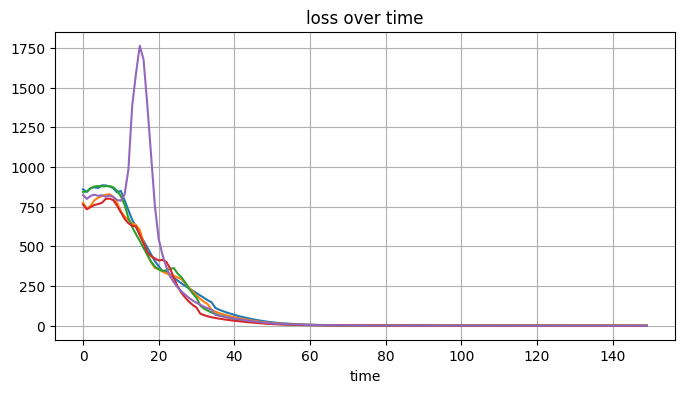

In [5]:
# Validation
# Set the random seed for reproducibility
torch.manual_seed(99)
t_ext = 150

x_log = torch.zeros(t_ext, syst.n, n_traj)
u_log = torch.zeros(t_ext, syst.m, n_traj)
loss_log = torch.zeros((t_ext, 1, n_traj))

for traj in range(n_traj):
    w_in = torch.randn((t_ext + 1, syst.n))
    # Compute the closed-loop trajectories using the trained controller and plot them
    devx0 = std_ini * torch.randn(x0.shape)
    x = x0.detach() + devx0
    xi = torch.zeros(ctl.n)
    w_REN = x0.detach() - syst.xbar + devx0
    u, xi = ctl(0, w_REN, xi)
    usys = amplifier(u)
    for t in range(t_ext):
        x_ = x
        x_log[t, :,traj] = x.detach()
        u_log[t, :,traj] = usys.detach()
        w_syst = disturbance(t, w_in[t, :], wmax, decayw, maxtimew)
        x = syst(t, x, usys, w_syst)
        w_REN = x - syst.f(t, x_, usys)
        u, xi = ctl(t, w_REN, xi)
        usys = amplifier(u)
        loss_x =  f_loss_states(t, x, syst, Q)
        loss_u = alpha_u * f_loss_u(t, usys)
        loss_ca = alpha_ca * f_loss_ca(x, syst, min_dist)
        if alpha_obst != 0:
            loss_obst =  alpha_obst * f_loss_obst(x)
        loss = loss_x + loss_u + loss_ca + loss_obst
        loss_log[t,:,traj] = loss.detach()

plot_traj_vs_time(t_end, syst.n_agents, x_log[:t_end,:,0], u_log[:t_end,:,0])
plot_trajectories(x_log, xbar, syst.n_agents, text="CL - after training - extended t", T=t_end, obst=alpha_obst)

# Compute the number of collisions and print the result
n_coll = calculate_collisions(x_log[:,:,0], syst, min_dist)
print("Number of collisions after training: %d" % n_coll)

time = torch.linspace(0, t_ext, t_ext+1)
plt.figure(figsize=(4 * 2, 4))
for traj in range(n_traj):
    plt.plot(time[:t_ext], loss_log[:,:,traj])
plt.xlabel('time')
plt.title('loss over time')
plt.grid()
plt.show()